# Modelling Hidden Confounders in Causal Inference: An Empirical Study with CEVAE

We are in the context of an **observational study**: we observe outcomes ($Y$) for available subjects (with many characteristics $X_i$) on the variables of interest ($T$) without control over this variable. This setting poses a problem: there may be lurking variables not taken into account who affect both the treatment and the outcome (i.e., confounders) making the establishment of cause and effect much harder.

This stands in contrast to Randomized Clinical Trials (RCTs), where instead we can randomize the assignment of the subjects to the values of the variable of interest so that no confounders are present.

**Causal Graphical Model (Causal Bayesian Network)**

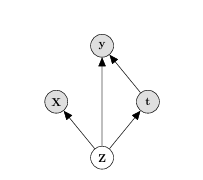

We **observe** the features $X_i$, the treatment $T$ and the outcome $Y$, but we do **not observe** the hidden confounder $Z$!

Our **objective** is to estimate the **Average Treatment Effect** (ATE), i.e., the effect of $T$ on $Y$.

All the evaluations are based on two metrics based on the Individual Treatment Effect (ITE), typical metric in causal inference problems, defined as:

...

RMSE of the ITE:

...

and the ATE error:

...

In [1]:
from data_gen import synthetic_dataset_non_linear, synthetic_dataset_linear
from dowhy import CausalModel
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pyro
from pyro.contrib.cevae import CEVAE
import torch
import matplotlib.pyplot as plt
import logging
from utils import LinearModel,PyroLinearProxyModel,run_experiment,abs_ate_error,rel_ate_error,rmse_ite,plot_three_experiment_results
import pandas as pd


logging.getLogger("pyro").setLevel(logging.DEBUG)
logging.getLogger("pyro").handlers[0].setLevel(logging.DEBUG)

In [2]:
data = synthetic_dataset_linear(n=1000, beta=2.0, num_proxies=10, seed=0)
data.keys()
length_x = len(data["x"][1]) 

#clone
data_original = data.copy()

In [3]:
# translating the dictionary in a dataframe
# I need to change the x matrix in different x columns
for i in range(data["x"].shape[1]):
    data["x_"+str(i)] = data["x"][:,i]

data.pop("x",None)

data_df = pd.DataFrame.from_dict(data)
data_df.head()

,t,y,z,ite,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,0.0,-1.868301,-1.125840,1.0,-10.419271,-0.488647,7.174606,-4.648432,-4.576821,7.489878,6.996157,-4.095944,0.897944,9.790544
1,0.0,-0.538289,-1.152360,1.0,-9.362418,2.158251,7.738794,-4.534320,-5.552610,6.954226,5.887638,-5.219081,1.483338,11.746528
2,0.0,-3.903064,-0.250579,1.0,-0.370637,-1.324946,1.612699,-1.358586,-0.889863,2.247172,-0.042243,-2.090028,0.893964,2.806923
3,1.0,1.080067,-0.433879,1.0,-3.855381,-1.410040,0.407185,-0.369522,-2.708030,4.276382,1.373499,-4.581057,0.293072,4.355963
4,0.0,1.667862,0.848710,1.0,8.152637,-0.456173,-5.582678,0.746877,3.758286,-4.447976,-5.754533,4.323848,-1.834779,-8.086730


We can obtain a naive estimate for the ATE by taking the mean of the outcome in the two groups in the dataset (those that received the treatment and those who didn't). We call this estimate "unadgusted" because we are not considering any of the covariates that can affect the treatment effect.

In [4]:
data_1 = data_df[data_df["t"]==1.0]
data_0 = data_df[data_df["t"]==0.0]

print("Unadjusted ATE", np.mean(data_1["y"])- np.mean(data_0["y"]))

Unadjusted ATE 2.1330922


## First strategy: assuming "No hidden confounders"

Assuming that there are no hidden confounders (also called **unconfoundness**) means that we consider the $X_i$ to be the only confounders and thus we consider them to be measured!

In this case the set of variables $X_i$ satisfy the back-door criterion and we can apply classical methods for causal inference.

In [5]:
# model = CausalModel(data_df, treatment="t", outcome="y", common_causes="z")
# this would be the real model since we know how the data was generated
# however, in a real setting, we don't usually have access to the real confounders and we consider the proxies variables we have for it instead  

model = CausalModel(data_df, treatment="t", outcome="y", common_causes=["x_"+str(i) for  i in range(0,10)])

In [6]:
# this doesn't work in all python enviroments, for reference look at the generated image
#model.view_model(file_name="causal_model_no_hidden_confounder")

We identify the **estimand** using the back-door criterion. Again, we remark the need for the unconfoundedness assumption.

The estimand type is **non parametric** because we are **not** assuming any parametric model for the treatment effect.

The other two types of estimand (instrumental variable and front-door criterion) are **not** available because there are no instrumental variables or mediators in the causal graph. 


In [7]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4,U) = P(y|t,x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



We want to compute how the value of $y$ will change with respect to $T$, controlling for all $X_i$.

For this purpose, we estimate the ATE using the linear regression to approximate the conditional probability $p(y|x,t)$.

In [8]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4,U) = P(y|t,x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4)

## Realized estimand
b: y~t+x_8+x_1+x_5+x_3+x_2+x_0+x_9+x_7+x_6+x_4
Target units: ate

## Estimate
Mean value: 0.8985665542871596
p-value: [4.33652909e-26]



We can also explicitely compute the linear regression using scikit-learn: we verify that the result is the same!

In [10]:
feature_cols = [f'x_{i}' for i in range(10)]
x = data_df[feature_cols]   
t = np.asarray(data_df['t'])
y = data_df['y']

linear_model = LinearModel()
linear_model.fit(x, t, y)          

ite = linear_model.ite(x)         
ate = ite.mean().item()
print("Average Treatment Effect (ATE):", ate)


Average Treatment Effect (ATE): 0.8985663056373596


We estimated that receiving the treatment (t=1) increases the outcome of $1.826$ units after adjusting for covariates. This estimates has a very small p-value, suggesting that this effect is statistically significant.

Other types of estimation are possible, we try a couple more.

In [11]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching", test_significance=True
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4,U) = P(y|t,x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4)

## Realized estimand
b: y~t+x_8+x_1+x_5+x_3+x_2+x_0+x_9+x_7+x_6+x_4
Target units: ate

## Estimate
Mean value: 1.0535086990594864
p-value: [0, 0.001]



In [12]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting", test_significance=True
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4,U) = P(y|t,x_8,x_1,x_5,x_3,x_2,x_0,x_9,x_7,x_6,x_4)

## Realized estimand
b: y~t+x_8+x_1+x_5+x_3+x_2+x_0+x_9+x_7+x_6+x_4
Target units: ate

## Estimate
Mean value: 1.0727630383026456
p-value: [0, 0.001]



With different estimation methods we have obtained the following results:
- $1.82$ with linear regression
- $1.66$  with propensity score matching
- $1.72$ with propensity score weighting

**Remark**: I also verified that, if I give to the model the real hidden confounder (Z), it correctly predicts a causal effect close to 1 for all estimation methods!

## Second strategy: keeping into account the latent variable

If we think that there must be an hidden confounder that we have to account for, we can use the Causal Effect Variational AutoEncoder (CEVAE) to try to estimate it based on the available data.


## PGM

Assume a simple graphical model, as the one defined by the problem. We assume the following general relationship

$$
Z\sim \mathcal{N}(0,1)\\
X\sim \mathcal{N}(az+b,\Sigma_X)\\
T|Z\sim \text{Bernoulli}(\sigma(cz))\\
Y|Z,T\sim\mathcal{N}(et+fz,\sigma_Y)
$$

we want to find all these parameters usign variational inference

In [133]:
from sklearn.model_selection import train_test_split

x, t, y, z, ite   = (
    data_original["x"],
    data_original["t"],
    data_original["y"],
    data_original["z"],
    data_original["ite"]
    )

x_train, x_test, t_train, t_test, y_train, y_test, z_train, z_test, ite_train, ite_test = train_test_split(
    x, t, y, z, ite, test_size=0.2, random_state=0
)

In [134]:
pgm = PyroLinearProxyModel(init_scale=0.1, learning_rate=5e-3, weight_decay=0.0)

losses = pgm.fit(x_train, t_train, y_train, num_epochs=1000, log_every=100, posterior_epochs=1000)          


[SVI] epoch  100 ELBO = 79756.26
[SVI] epoch  200 ELBO = 50908.48
[SVI] epoch  300 ELBO = 35673.48
[SVI] epoch  400 ELBO = 27437.59
[SVI] epoch  500 ELBO = 23061.04
[SVI] epoch  600 ELBO = 20733.48
[SVI] epoch  700 ELBO = 19285.69
[SVI] epoch  800 ELBO = 18442.93
[SVI] epoch  900 ELBO = 17904.61
[SVI] epoch 1000 ELBO = 17589.25
[SVI-xt] epoch  101 ELBO = 43988.32
[SVI-xt] epoch  201 ELBO = 35267.57
[SVI-xt] epoch  301 ELBO = 29386.97
[SVI-xt] epoch  401 ELBO = 25430.58
[SVI-xt] epoch  501 ELBO = 22761.25
[SVI-xt] epoch  601 ELBO = 20641.04
[SVI-xt] epoch  701 ELBO = 19281.46
[SVI-xt] epoch  801 ELBO = 18410.60
[SVI-xt] epoch  901 ELBO = 17762.43


In [137]:
ite = pgm.ite_train(x_train)         
ate = ite.mean().item()
# Compute mean squared error between true ITE and computed ITE
true_ite = ite_train
mse = torch.mean((ite.flatten() - true_ite.flatten()) ** 2).item()

print("Results for training data")
print("Average Treatment Effect (ATE) (through ITE)", ate)
print("Estimated ATE fro model coefficients (by def):", pgm.estimate_ate())
print("Mean Squared Error between true ITE and computed ITE:", mse)
# print(ite)

Results for training data
Average Treatment Effect (ATE) (through ITE) 0.9919602870941162
Estimated ATE fro model coefficients (by def): 0.9925326108932495
Mean Squared Error between true ITE and computed ITE: 0.00024796859361231327


here for each $z_i$ there is a pair $(\mu_i,\sigma_i)$, so if we want to predict $z$ for unseen values of $x$ we must train again the model on the new data points.

In [111]:
loc   = pyro.param("AutoDiagonalNormal.loc")   # shape [N]
scale = pyro.param("AutoDiagonalNormal.scale") # shape [N]

# Example: pick out the first few
for i in range(10):
    print(f"z_{i} ~ Normal(mean={loc[i].item():.2f}, std={scale[i].item():.2f})")

z_0 ~ Normal(mean=0.95, std=0.20)
z_1 ~ Normal(mean=-0.56, std=0.19)
z_2 ~ Normal(mean=-0.14, std=0.20)
z_3 ~ Normal(mean=-3.10, std=0.15)
z_4 ~ Normal(mean=-3.02, std=0.14)
z_5 ~ Normal(mean=3.27, std=0.12)
z_6 ~ Normal(mean=-2.87, std=0.16)
z_7 ~ Normal(mean=0.31, std=0.21)
z_8 ~ Normal(mean=3.22, std=0.17)
z_9 ~ Normal(mean=-0.37, std=0.21)


trying to predict on the test set; this requires local refit (doable only for small test samples and for theory sake)

In [131]:
ite_pred = pgm.ite(x_test)
true_ite = ite_test
mse = torch.mean((ite_pred.flatten() - true_ite.flatten()) ** 2).item()

print("Predicted ITEs:", ite_pred)
print("Mean Squared Error between predicted ITE and true ITE:", mse)
ate_pred = pgm.estimate_ate()
print("Predicted ATE (through ITE)", ite_pred.mean(0).item())
print("Predicted ATE (with params):", ate_pred)


Predicted ITEs: tensor([0.9369, 1.2208, 1.0788, 1.3414, 1.3670, 1.0086, 0.8424, 0.8446, 1.1771,
        0.8441, 0.9693, 0.9295, 1.0772, 1.1324, 1.4134, 1.5283, 1.0048, 1.3145,
        0.5748, 0.7967, 0.8977, 0.8434, 0.8592, 0.9852, 0.9980, 1.1298, 1.1710,
        1.2528, 1.3343, 1.0248, 0.7869, 1.0825, 1.1660, 1.2306, 1.1909, 0.9468,
        1.1728, 1.2014, 0.7750, 1.1641, 1.1512, 1.3917, 0.9973, 1.1019, 0.9809,
        1.1220, 0.9180, 0.9776, 1.2464, 1.0929, 1.1656, 0.6406, 1.0337, 0.7809,
        1.0468, 0.9897, 1.1602, 1.1711, 1.1336, 1.2453, 0.9217, 0.9586, 0.6912,
        1.3028, 0.7544, 0.9477, 1.0483, 0.8352, 0.9959, 0.7911, 1.2958, 0.9352,
        0.8459, 0.8624, 0.6938, 0.7718, 0.8055, 0.9121, 1.1916, 0.7856, 1.1318,
        0.8484, 0.8365, 1.1151, 0.9529, 1.3956, 1.1124, 1.2710, 0.9999, 1.1026,
        0.9273, 0.6417, 1.0329, 1.1649, 1.0459, 0.7539, 1.0446, 0.7814, 1.1657,
        0.8208, 0.8615, 0.4707, 0.8746, 1.0911, 0.7184, 0.7828, 0.9454, 1.1109,
        1.1027, 1.1211, 

## CEVAE

In [16]:
x, t, y   = (
    data_original["x"],
    data_original["t"],
    data_original["y"]
    )

z = data_original["z"]

length_x  = x.shape[1]

# ----------------------------- train-test split ----------------------------- #

x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(
    x, t, y, test_size=0.2, random_state=0
)

INFO 	 Training with 8 minibatches per epoch
DEBUG 	 step     0 loss = 28.5278
DEBUG 	 step   100 loss = 10.5508
DEBUG 	 step   200 loss = 12.6559
DEBUG 	 step   300 loss = 7.82905
DEBUG 	 step   400 loss = 7.2236
DEBUG 	 step   500 loss = 6.51202
DEBUG 	 step   600 loss = 6.39632
DEBUG 	 step   700 loss = 6.7175


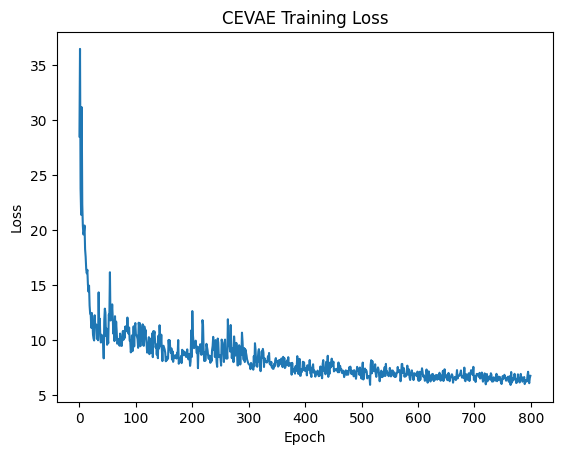

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.927972


Estimated (test) ATE: 0.9280
True ATE: 1.0000


In [17]:
# before every training run
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

losses = cevae.fit(
    x_train, t_train, y_train,
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    # learning_rate_decay=0.1,
    # weight_decay=1e-6
    )

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

# Estimate ITEs and ATE
ite = cevae.ite(x_test)
ate = ite.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

In [18]:
# Save the model
torch.save(cevae, "cevae_model_full.pth")

cevae_loaded = torch.load("cevae_model_full.pth", weights_only=False)

## Experiments

### Plot also the test loss

In [13]:
import torch, types
from torch.utils.data import DataLoader, TensorDataset
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.optim import ClippedAdam
from pyro.contrib.cevae import PreWhitener, TraceCausalEffect_ELBO

def train_cevae(
    model,                      # a CEVAE instance
    x, t, y,                    # training data
    x_val=None, t_val=None, y_val=None,   # optional validation data
    num_epochs=100, batch_size=100,
    lr=1e-3, lr_decay=0.1, weight_decay=1e-4,
    log_every=10,
):
    model.whiten = PreWhitener(x)           # <-- same pre-whiten stats
    train_loader = DataLoader(TensorDataset(x, t, y),
                              batch_size=batch_size, shuffle=True,
                              generator=torch.Generator(device=x.device))
    num_steps = num_epochs * len(train_loader)
    optim = ClippedAdam({"lr": lr,
                         "weight_decay": weight_decay,
                         "lrd": lr_decay ** (1/num_steps)})
    svi = SVI(model.model, model.guide, optim, TraceCausalEffect_ELBO())
    tr_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # ---- training pass
        epoch_loss = 0.0
        for xb, tb, yb in train_loader:
            xb = model.whiten(xb)
            batch_loss = svi.step(xb, tb, yb, size=len(x))
            batch_loss = batch_loss / len(x)
            epoch_loss += batch_loss

        tr_losses.append(epoch_loss / len(train_loader))

        # ---- validation pass (optional)
        if x_val is not None:
            with torch.no_grad():
                xv = model.whiten(x_val)
                vloss = svi.evaluate_loss(xv, t_val, y_val,
                                          size=len(x_val)) / len(x_val)
            val_losses.append(vloss)

        if log_every and (epoch+1) % log_every == 0:
            msg = f"[{epoch+1:03d}] train={tr_losses[-1]:.4f}"
            if x_val is not None:
                msg += f" | val={val_losses[-1]:.4f}"
            print(msg)

    return (tr_losses, val_losses) if x_val is not None else tr_losses


In [20]:
# before every training run
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=3,
    hidden_dim=200
    )

train_losses, val_losses = train_cevae(
    cevae,
    x_train, t_train, y_train,
    x_val=x_test, t_val=t_test, y_val=y_test,
    num_epochs=100,
    batch_size=100,
    lr=5e-3,
    # learning_rate_decay=0.1,
    # weight_decay=1e-6
    )


[010] train=9.7000 | val=8.9607
[020] train=9.5454 | val=8.5632
[030] train=7.9597 | val=8.4052
[040] train=7.4899 | val=6.8194
[050] train=6.9797 | val=7.1849
[060] train=7.1704 | val=7.6734
[070] train=6.7666 | val=6.9062
[080] train=6.6731 | val=7.1330
[090] train=6.4585 | val=6.7173
[100] train=6.3660 | val=6.9096


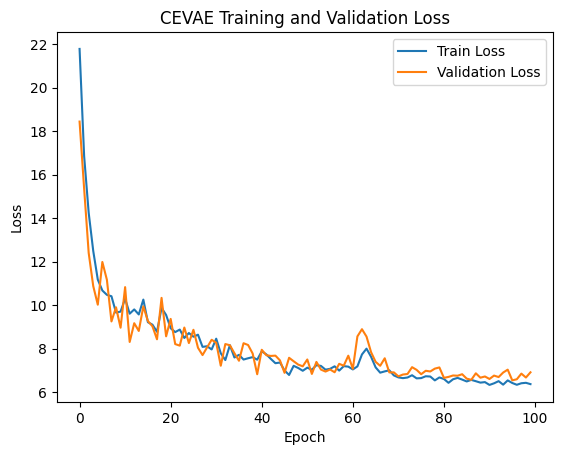

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.00244


Estimated (test) ATE: 1.0024
True ATE: 1.0000


In [21]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training and Validation Loss')
plt.legend()
plt.show()

# Estimate ITEs and ATE
ite = cevae.ite(x_test)
ate = ite.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

### General function for the experiments

In [139]:
def plot_experiment_results(results, x_param="data__shuffle_pct"):
    """
    Given a DataFrame `results` where one column is your swept parameter
    (e.g. "data__shuffle_pct") and the others are metrics, this function
    will produce one plot per metric.
    """
    # find all metric columns
    metrics = [c for c in results.columns if c != x_param]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(results[x_param], results[metric], marker="o")
        plt.xlabel(x_param)
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}")
        plt.tight_layout()
        plt.show()

In [140]:
def plot_two_experiment_results(results, linear_results, x_param="data__shuffle_pct"):
    """
    Plot results and linear_results overlapping for each metric on the same plot.
    Assumes both DataFrames have the same x_param values and metric columns.
    """
    # find all metric columns
    metrics = [c for c in results.columns if c != x_param and c!= "final_elbo"]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(results[x_param], results[metric], marker="o", label="Results")
        plt.plot(linear_results[x_param], linear_results[metric], marker="x", label="Linear Results")
        plt.xlabel(x_param)
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [15]:
def plot_three_experiment_results(ceave_res, linear, pgm, x_param="data__shuffle_pct"):
    """
    Plot results and linear_results overlapping for each metric on the same plot.
    Assumes both DataFrames have the same x_param values and metric columns.
    """
    # find all metric columns
    metrics = [c for c in ceave_res.columns if c != x_param and c!= "final_elbo"]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(ceave_res[x_param], ceave_res[metric], marker="o", label="CEVAE")
        plt.plot(linear[x_param], linear[metric], marker="x", label="Linear Regression")
        plt.plot(pgm[x_param], pgm[metric], marker="^", label="PGM")
        plt.xlabel(x_param)
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}")
        plt.legend()
        plt.tight_layout()
        plt.show()


### Setting parameters defaults

In [2]:
num_proxies = 10
n_data = 200

data_defaults_non_lin = dict(
    n=n_data,
    num_proxies=num_proxies,
    sigma_x=1.0,
    sigma_y=1.0,
    prior_type="gaussian",
    seed=0,
)

data_defaults_linear = dict(
    n=n_data,
    beta=1.0,
    num_proxies=num_proxies,
    shuffle_pct=0.0,
    sigma_x=1.0,
    sigma_y=1.0,
    seed=0,
)

model_defaults = dict(
    feature_dim=num_proxies,
    latent_dim=1,
    num_layers=3,   # number of hidden layers
    hidden_dim=200,  # number of hidden units in each layer
    outcome_dist="normal",
)

fit_defaults = dict(
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-3,
    weight_decay=0.0,
    log_every=0,
)

pgm_fit_defaults = dict(
    num_epochs=1000,
    posterior_epochs=1000,
    batch_size=100,  # ignored here, we do full-batch
    learning_rate=5e-3,
    weight_decay=0.0,
    log_every=100,
)

metrics = {
    "abs_ate_err": rel_ate_error,
    "rmse_ite": rmse_ite,
}

# fixing the experiment data generating function


#### Choosing the dataset

In [3]:

dataset_type = "non_linear"  # or "non_linear"

if dataset_type == "non_linear":
    data_gen_fn = synthetic_dataset_non_linear
    data_defaults = data_defaults_non_lin
elif dataset_type == "linear":
    data_gen_fn = synthetic_dataset_linear
    data_defaults = data_defaults_linear


### E1: increasing sample size

In [178]:
# set up params to sweep
param_grid = {
    "data__n": np.linspace(100,1000,10, dtype=int),
}

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

INFO 	 Training with 1 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.5053
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.568
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.76514
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.78424
INFO 	 Training with 3 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.62473
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.60447
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.34306
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.3546
INFO 	 Training with 4 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.30809
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.33151
INFO 	 Training with 5 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.52163
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.52634
INFO 	 Trainin

   data__n  final_elbo  abs_ate_err  rmse_ite
0      100   16.625145     0.669878  0.895304
1      200   16.970142     0.820094  1.038314
2      300   17.390036     0.564921  0.703658
3      400   15.928269     0.356970  0.528445
4      500   17.782076     0.328668  0.471549
5      600   17.550144     0.477050  0.584648
6      700   17.605917     0.286863  0.488548
7      800   17.779930     0.905519  0.945903
8      900   17.944575     0.393658  0.494718
9     1000   17.707049     0.178406  0.397980
   data__n  final_elbo  abs_ate_err  rmse_ite
0      100    1.507097     0.504211  0.595850
1      200    1.363580     0.701620  0.838889
2      300    1.601729     0.810609  0.989169
3      400    1.192751     0.565327  0.767638
4      500    1.710758     0.767079  0.907385
5      600    1.409633     0.456945  0.713822
6      700    1.673513     0.648593  0.844288
7      800    1.587039     0.788339  0.924651
8      900    1.309255     0.522562  0.736173
9     1000    1.469740     0.45787

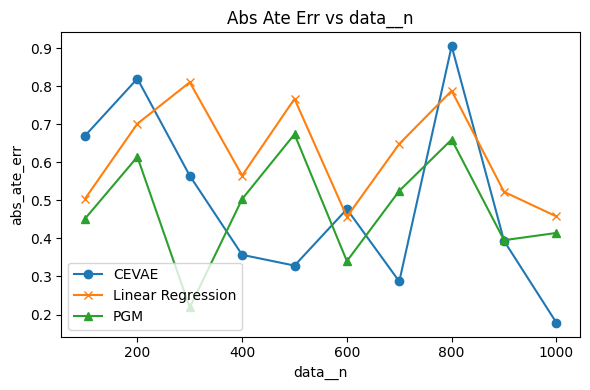

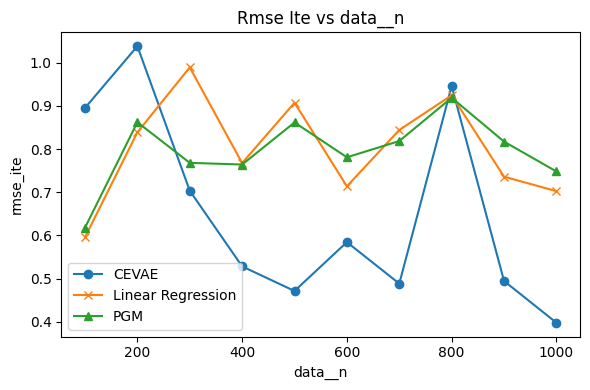

In [187]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__n")

### E2: increasing correlation among proxies (not through $Z$)

In [192]:
# set up params to sweep
param_grid = {
    "data__rho": np.linspace(0.0, 0.9, 10),
}

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 3134.42
[SVI] epoch  200 ELBO = 2797.06
[SVI] epoch  300 ELBO = 2757.86
[SVI] epoch  400 ELBO = 2752.14
[SVI] epoch  500 ELBO = 2748.45
[SVI] epoch  600 ELBO = 2745.01
[SVI] epoch  700 ELBO = 2745.47
[SVI] epoch  800 ELBO = 2738.95
[SVI] epoch  900 ELBO = 2743.17
[SVI] epoch 1000 ELBO = 2744.03
[SVI-xt] epoch  101 ELBO = 2600.02
[SVI-xt] epoch  201 ELBO = 2495.26
[SVI-xt] epoch  301 ELBO = 2484.41
[SVI-xt] epoch  401 ELBO = 2485.26
[SVI-xt] epoch  501 ELBO = 2485.51
[SVI-xt] epoch  601 ELBO = 2482.30
[SVI-xt] epoch  701 ELBO = 2486.92
[SVI-xt] epoch  801 ELBO = 2486.59
[SVI-xt] epoch  901 ELBO = 2484.31
[SVI] epoch  100 ELBO = 3094.99
[SVI] epoch  200 ELBO = 2796.50
[SVI] epoch  300 ELBO = 2758.73
[SVI] epoch  400 ELBO = 2752.62
[SVI] epoch  500 ELBO = 2748.64
[SVI] epoch  600 ELBO = 2744.70
[SVI] epoch  700 ELBO = 2745.45
[SVI] epoch  800 ELBO = 2739.01
[SVI] epoch  900 ELBO = 2743.29
[SVI] epoch 1000 ELBO = 2744.11
[SVI-xt] epoch  101 ELBO = 2599.21
[SVI-xt] e

INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.76514
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.78424
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.80058
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.81895
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.80772
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.8011
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.93535
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.92239
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.81488
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.81078
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.92709
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.93044
INFO 	 Trai

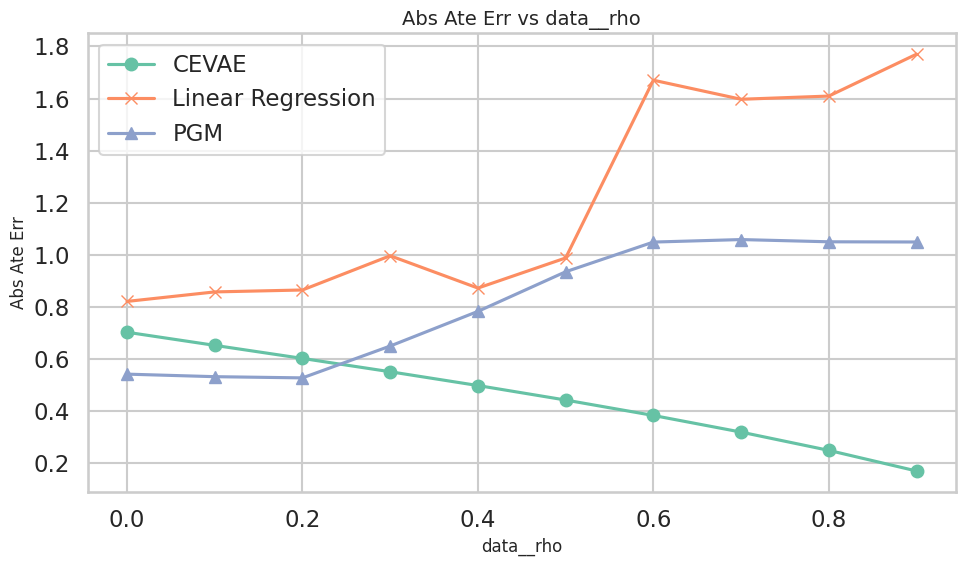

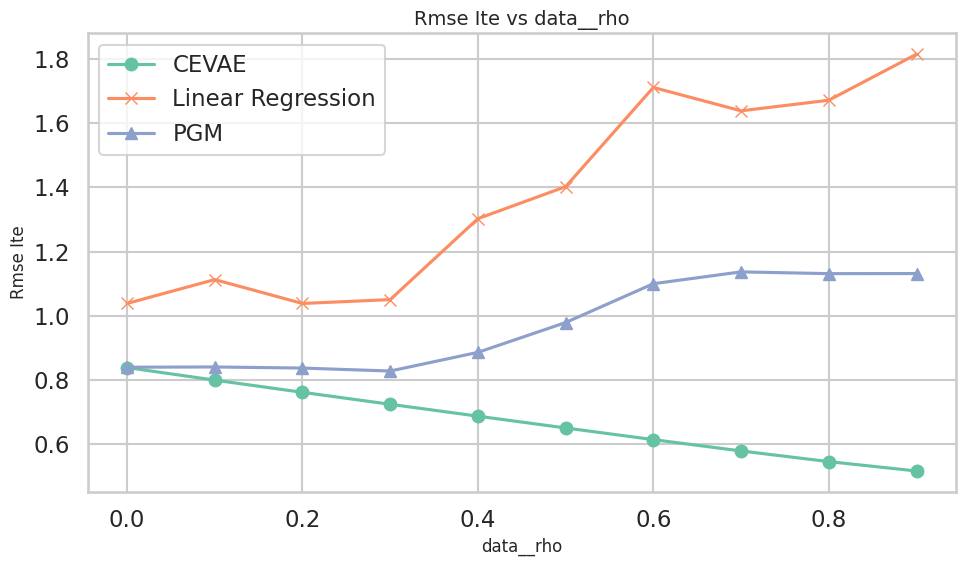

In [197]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__rho")

### E3: increasing decorellation among proxies (through shuffling)

In [198]:
# set up params to sweep
param_grid = {
    "data__shuffle_pct": np.linspace(0.0, 1.0, 11)
}

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 3134.42
[SVI] epoch  200 ELBO = 2797.06
[SVI] epoch  300 ELBO = 2757.86
[SVI] epoch  400 ELBO = 2752.14
[SVI] epoch  500 ELBO = 2748.45
[SVI] epoch  600 ELBO = 2745.01
[SVI] epoch  700 ELBO = 2745.47
[SVI] epoch  800 ELBO = 2738.95
[SVI] epoch  900 ELBO = 2743.17
[SVI] epoch 1000 ELBO = 2744.03
[SVI-xt] epoch  101 ELBO = 2600.02
[SVI-xt] epoch  201 ELBO = 2495.26
[SVI-xt] epoch  301 ELBO = 2484.41
[SVI-xt] epoch  401 ELBO = 2485.26
[SVI-xt] epoch  501 ELBO = 2485.51
[SVI-xt] epoch  601 ELBO = 2482.30
[SVI-xt] epoch  701 ELBO = 2486.92
[SVI-xt] epoch  801 ELBO = 2486.59
[SVI-xt] epoch  901 ELBO = 2484.31
[SVI] epoch  100 ELBO = 3085.43
[SVI] epoch  200 ELBO = 2823.95
[SVI] epoch  300 ELBO = 2790.07
[SVI] epoch  400 ELBO = 2780.67
[SVI] epoch  500 ELBO = 2781.62
[SVI] epoch  600 ELBO = 2774.52
[SVI] epoch  700 ELBO = 2773.63
[SVI] epoch  800 ELBO = 2776.29
[SVI] epoch  900 ELBO = 2773.81
[SVI] epoch 1000 ELBO = 2772.07
[SVI-xt] epoch  101 ELBO = 2613.60
[SVI-xt] e

INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.76514
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.78424
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.20731
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.21734
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.23404
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.23397
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.72278
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.74343
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.36866
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.37441
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.51608
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.53531
INFO 	 Tra

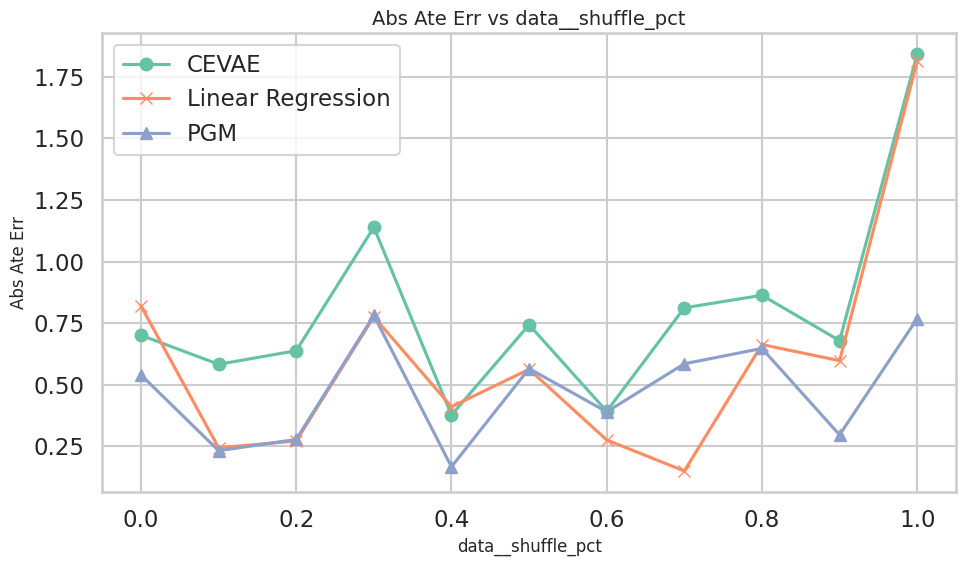

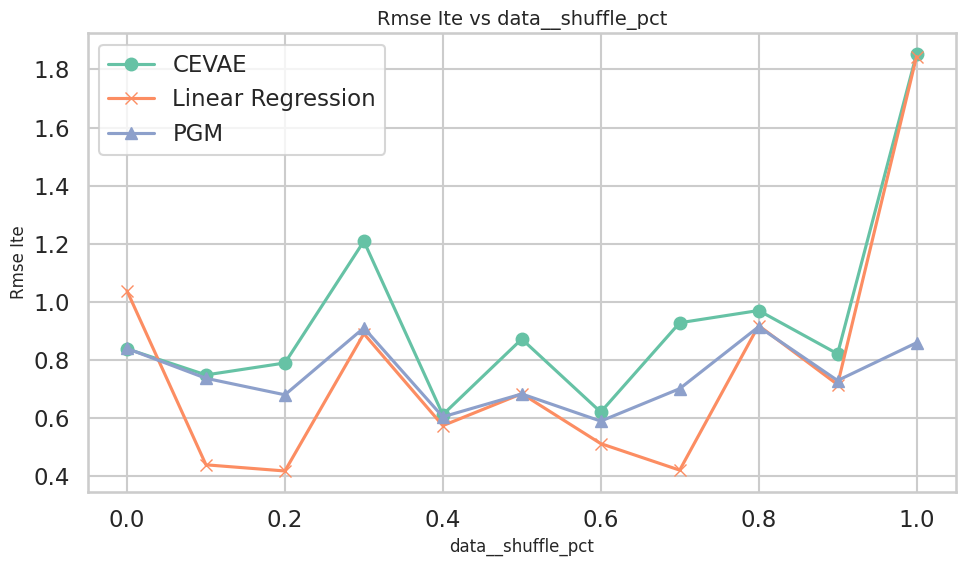

In [200]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__shuffle_pct")

### E4: increasing proxies variance

### E5: increasing outcome variance

### E6: increasing the latent dimension (of the CEVAE)

In [ ]:
# set up params to sweep
param_grid = {
    "model__latent_dim": [1, 2, 5, 10, 20],
}

# run the experiment
res = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_non_linear,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

### E7: prior misspecification

In [4]:
# set up params to sweep
param_grid = {
    "data__prior_type": ["gaussian", "bimodal"],  # type of prior distribution
}

results_pgm = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = PyroLinearProxyModel,
    model_kwargs  = {},      
    fit_kwargs   = pgm_fit_defaults,
    metrics_fns  = metrics,                   
)

results_cevae = run_experiment(
    param_grid,
    data_fn=data_gen_fn,
    data_kwargs=data_defaults,
    model_cls=CEVAE,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
    metrics_fns=metrics,
)

results_lr = run_experiment(
    param_grid   = param_grid,
    data_fn      = data_gen_fn,  
    data_kwargs = data_defaults,
    model_cls    = LinearModel,
    metrics_fns  = metrics,                   
    model_kwargs  = {},      
    fit_kwargs   = {},
)

[SVI] epoch  100 ELBO = 3134.42
[SVI] epoch  200 ELBO = 2797.06
[SVI] epoch  300 ELBO = 2757.86
[SVI] epoch  400 ELBO = 2752.14
[SVI] epoch  500 ELBO = 2748.45
[SVI] epoch  600 ELBO = 2745.01
[SVI] epoch  700 ELBO = 2745.47
[SVI] epoch  800 ELBO = 2738.95
[SVI] epoch  900 ELBO = 2743.17
[SVI] epoch 1000 ELBO = 2744.03
[SVI-xt] epoch  101 ELBO = 2600.02
[SVI-xt] epoch  201 ELBO = 2495.26
[SVI-xt] epoch  301 ELBO = 2484.41
[SVI-xt] epoch  401 ELBO = 2485.26
[SVI-xt] epoch  501 ELBO = 2485.51
[SVI-xt] epoch  601 ELBO = 2482.30
[SVI-xt] epoch  701 ELBO = 2486.92
[SVI-xt] epoch  801 ELBO = 2486.59
[SVI-xt] epoch  901 ELBO = 2484.31
[SVI] epoch  100 ELBO = 2988.30
[SVI] epoch  200 ELBO = 2787.75
[SVI] epoch  300 ELBO = 2702.86
[SVI] epoch  400 ELBO = 2683.22
[SVI] epoch  500 ELBO = 2665.49
[SVI] epoch  600 ELBO = 2660.40
[SVI] epoch  700 ELBO = 2654.06
[SVI] epoch  800 ELBO = 2649.68
[SVI] epoch  900 ELBO = 2646.65
[SVI] epoch 1000 ELBO = 2643.05
[SVI-xt] epoch  101 ELBO = 2461.96
[SVI-xt] e

INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.76514
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.78424
INFO 	 Training with 2 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.14725
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.16409


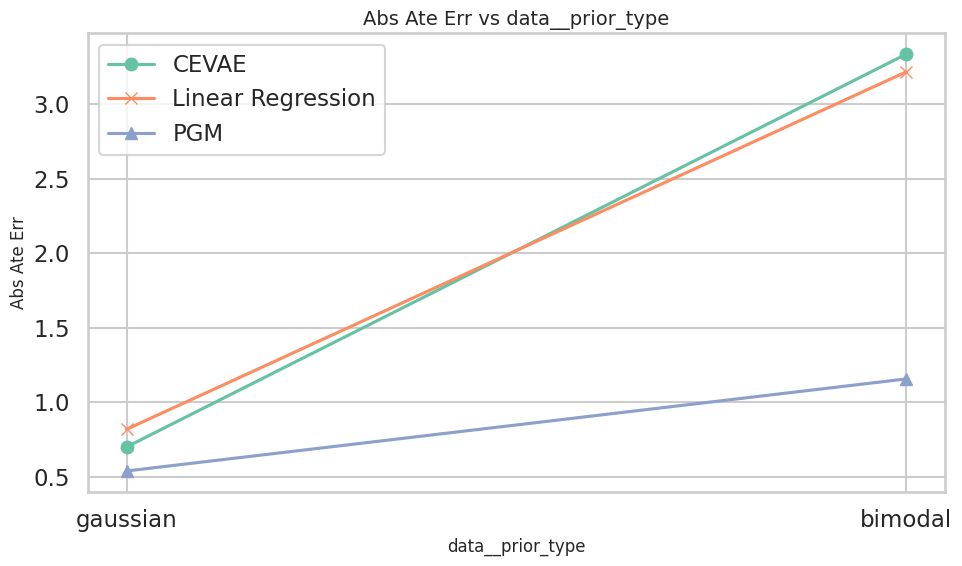

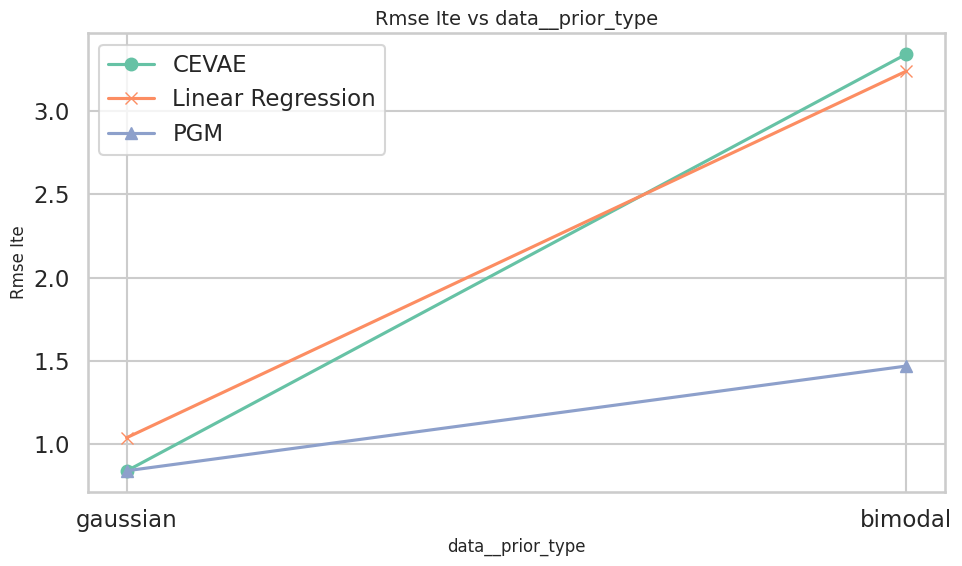

In [5]:
plot_three_experiment_results(results_lr, results_cevae,results_pgm, x_param="data__prior_type")

### E8: confounder strenght

### E9: increasing number of proxies

From this experiment we can see two things:
1. for a fixed number of data ($n=1000$) the performance of the model improves as the number of proxies increase. This make sense: the core idea of the use of VAEs to perform causal inference is that we are able to estimate the latent confounder in the big data regime, *i.e.*, in under the assumption that we have enough proxy variable of it. This is  pretty interestin result since nowadays we are in the big data regine. So given enough proxies we can estimate z better and better.
2. the minimum of the loss increases **linearly** when we increase the number of proxies. Does this make sense? Is the Elbow directly proportional (linearly) in the number of proxies (in the paper called $D_x$)? Yes.
The reconstruction term of $x$ 
$$
\mathbb{E}_q[\log(p(x|z))]
$$
where 

$$
\log(p(x|z))=\sum_{j=1}^{D_x}\log(p(x_j|z))
$$

and $p(x_j|z)\sim\mathcal{N}(\mu,\sigma^2)$, hence:

$$
\log(p(x|z))=\sum_{j=1}^{D_x}\frac{1}{2}[\log(2\pi\sigma^2)+\frac{(x_j-\mu_j(z))^2}{\sigma^2}]
$$

and for fixed $\sigma$ it is increasing with $D_x$